In [63]:
%matplotlib inline
import os
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import pandas as pd
from tabulate import tabulate
from scipy.interpolate import PchipInterpolator

import lsst.afw.cameraGeom
from lsst.obs.lsst import LsstCam
camera = LsstCam.getCamera()
det_names = {i: det.getName() for i, det in enumerate(camera)}
det_ptypes = {i: det.getPhysicalType() for i, det in enumerate(camera)}
det_nums = {det.getName():i for i, det in enumerate(camera)}
segments = [amp.getName() for amp in camera[1].getAmplifiers()]  #these are in order of amp

# get corrected SLAC QE data, with select BNL data

In [3]:
df_slac = pd.read_parquet('qe_raft_allvalues_corrected_20230724.parquet')

In [11]:
print(df_slac)

        idet           wl         qe slot  bay  seg
0          0   319.993988  48.629013  S00  R01  Ave
1          0   319.993988  49.821590  S00  R01  C10
2          0   319.993988  49.369022  S00  R01  C11
3          0   319.993988  49.053307  S00  R01  C12
4          0   319.993988  48.884781  S00  R01  C13
...      ...          ...        ...  ...  ...  ...
111991   188  1099.989990   2.277960  S22  R43  C04
111992   188  1099.989990   2.280380  S22  R43  C03
111993   188  1099.989990   2.281878  S22  R43  C02
111994   188  1099.989990   2.280678  S22  R43  C01
111995   188  1099.989990   2.259089  S22  R43  C00

[111996 rows x 6 columns]


# get Si absoption curve, check that data past Lambda>1000 is reasonable

In [4]:
# from Steve Ritz:  model of Rajkanan et al to obtain the absorption coefficient, for T=180K, see https://www.sciencedirect.com/science/article/pii/003811017990128X
# lam in nm and T in Kelvin
# alpha is in units of cm^-1
def alpham(lam,T):
    eg=[0]*2
    ep=[0]*2
    c=[0]*2
    A=[0]*2
    c[0]=5.5
    c[1]=4.0
    A[0]=3.231e2
    A[1]=7.237e3
    ep[0]=1.827e-2
    ep[1]=5.773e-2
    beta=7.021e-4
    k=8.62e-5
    kT=k*T
    hbar=6.582e-16
    omega=2*np.pi*3e+10/(lam*1e-7)  # need lambda in cm
    eg[0]=1.1557-(beta*T**2)/(T+1108)
    eg[1]=2.5-(beta*T**2)/(T+1108)
    egd=3.2-(beta*T**2)/(T+1108)
    alpha=0.
    if (hbar*omega>egd):
        alpha=1.052e+6*(hbar*omega-egd)**0.5
    for i in range(2):
        for j in range(2):
            if ((hbar*omega+ep[i])>eg[j]):
                alpha+=c[i]*A[j]*((hbar*omega-eg[j]+ep[i])**2)/(np.exp(ep[i]/kT)-1)
            if ((hbar*omega-ep[i])>eg[j]):
                alpha+=c[i]*A[j]*((hbar*omega-eg[j]-ep[i])**2)/(1-np.exp(-ep[i]/kT))
    return alpha  

Text(0, 0.5, 'Absoption Coefficient [cm^-1]')

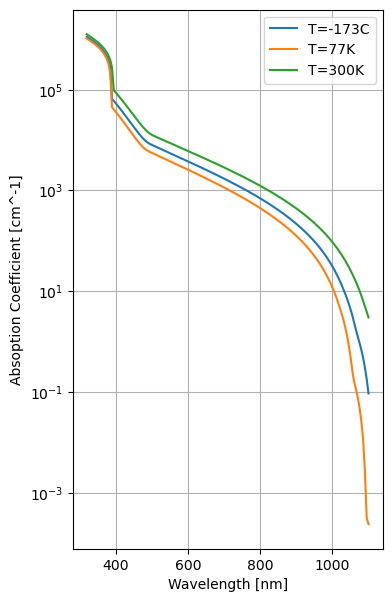

In [5]:
waves = np.arange(320.,1100.+5.,5.)
T = 273.16 - 100.0 # in Kelvin
alphas_100 = np.array([alpham(lam,T) for lam in waves])

T = 273.16 - 105.0 # in Kelvin
alphas_105 = np.array([alpham(lam,T) for lam in waves])

T = 273.16 - 95.0 # in Kelvin
alphas_95 = np.array([alpham(lam,T) for lam in waves])

T = 300.0 # in Kelvin
alphas_300 = np.array([alpham(lam,T) for lam in waves])
T = 77 # in Kelvin
alphas_77 = np.array([alpham(lam,T) for lam in waves])

f,ax = plt.subplots(1,1,figsize=(4,7))
h = ax.plot(waves,alphas_100,label="T=-173C")
h = ax.plot(waves,alphas_77,label="T=77K")
h = ax.plot(waves,alphas_300,label="T=300K")

ax.legend()
ax.grid()
ax.set_yscale('log')
ax.set_xlabel('Wavelength [nm]')
ax.set_ylabel('Absoption Coefficient [cm^-1]')

![Si Absorption length](Images/SiAbsorption.png)

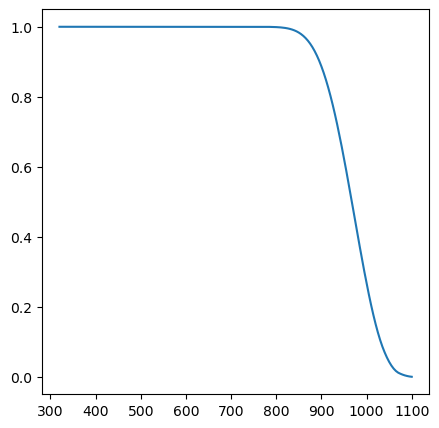

In [6]:
# convert to Probability of absoption in 100microns
L = 100.0 * 1.0e-4 # convert to cm
prob_100 = 1.0 - np.exp(-alphas_100*L)

f,ax = plt.subplots(1,1,figsize=(5,5))
h = ax.plot(waves,prob_100)

In [14]:
def get_idets(bay):
    
    baylist = []
    for i,det in enumerate(camera):
        if det.getName()[0:3]==bay:
            baylist.append(det.getId())
    return baylist

# normalize at a given wavelength and overplot
def redcompare_ccd_qe_raft(bay,dfall,wlnorm=825.,ccdtemp=-100.0,label1='SLAC',wlrange=(320.,1100.),uselog=False):

    idetlist = get_idets(bay)
    delwl = 5.0
    waves = np.arange(wlrange[0],wlrange[1]+delwl,delwl)

    T = 273.16 + ccdtemp # in Kelvin
    alphas = np.array([alpham(lam,T) for lam in waves])
    L = 100.0 * 1.0e-4 # convert to cm
    prob_100 = 1.0 - np.exp(-alphas*L)
    
    f,ax = plt.subplots(3,3,figsize=(12,12))
    
    # ax.flatten() yields:     0 1 2
    #                          3 4 5
    #                          6 7 8 
    #
    # idetlist is in this order from S00 to S22:     6 7 8
    #                                                3 4 5
    #                                                0 1 2
    # reorder axf to match
    axf = []
    axf.append(ax[2,0])
    axf.append(ax[2,1])
    axf.append(ax[2,2])
    axf.append(ax[1,0])
    axf.append(ax[1,1])
    axf.append(ax[1,2])
    axf.append(ax[0,0])
    axf.append(ax[0,1])
    axf.append(ax[0,2])
    
    
    for i,idet in enumerate(idetlist):
        
        dfone = dfall[(dfall.idet==idet) & (dfall.seg=='Ave')]
        x1 = dfone['wl']
        y1 = dfone['qe']
        aninterp1 = PchipInterpolator(x1,y1,extrapolate=True)
        
        qe1 = aninterp1(waves)
        
        # normalize 
        qenorm = aninterp1(wlnorm)
        
        h = axf[i].plot(x1,y1,'s',label=label1)
        h = axf[i].plot(waves,qenorm*prob_100,'-',label='Si absorption')

        axf[i].set_xlabel('Wavelength [nm]')
        axf[i].set_ylabel('QE %')
        axf[i].set_title('Detector #%d %s'%(idet,det_names[idet]))
        axf[i].legend()
        
        if uselog:
            axf[i].set_yscale('log')
        
    f.suptitle('CCD Raft Bay %s'%(bay),size='xx-large')
    f.tight_layout()
    f.savefig('qe_comparison_raft_%s.png'%(bay))
    

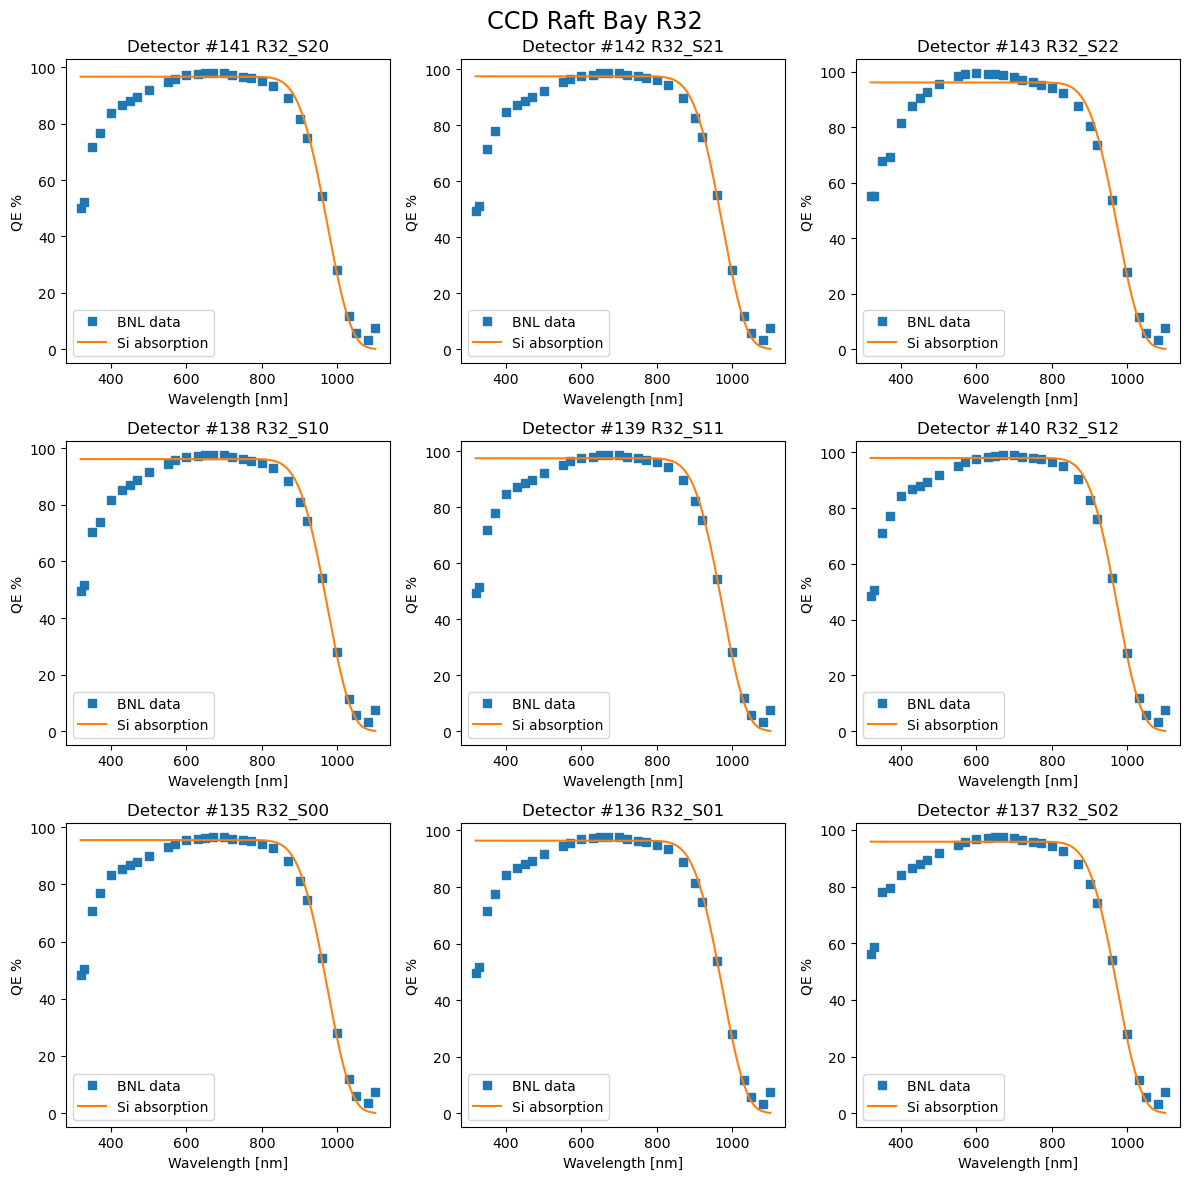

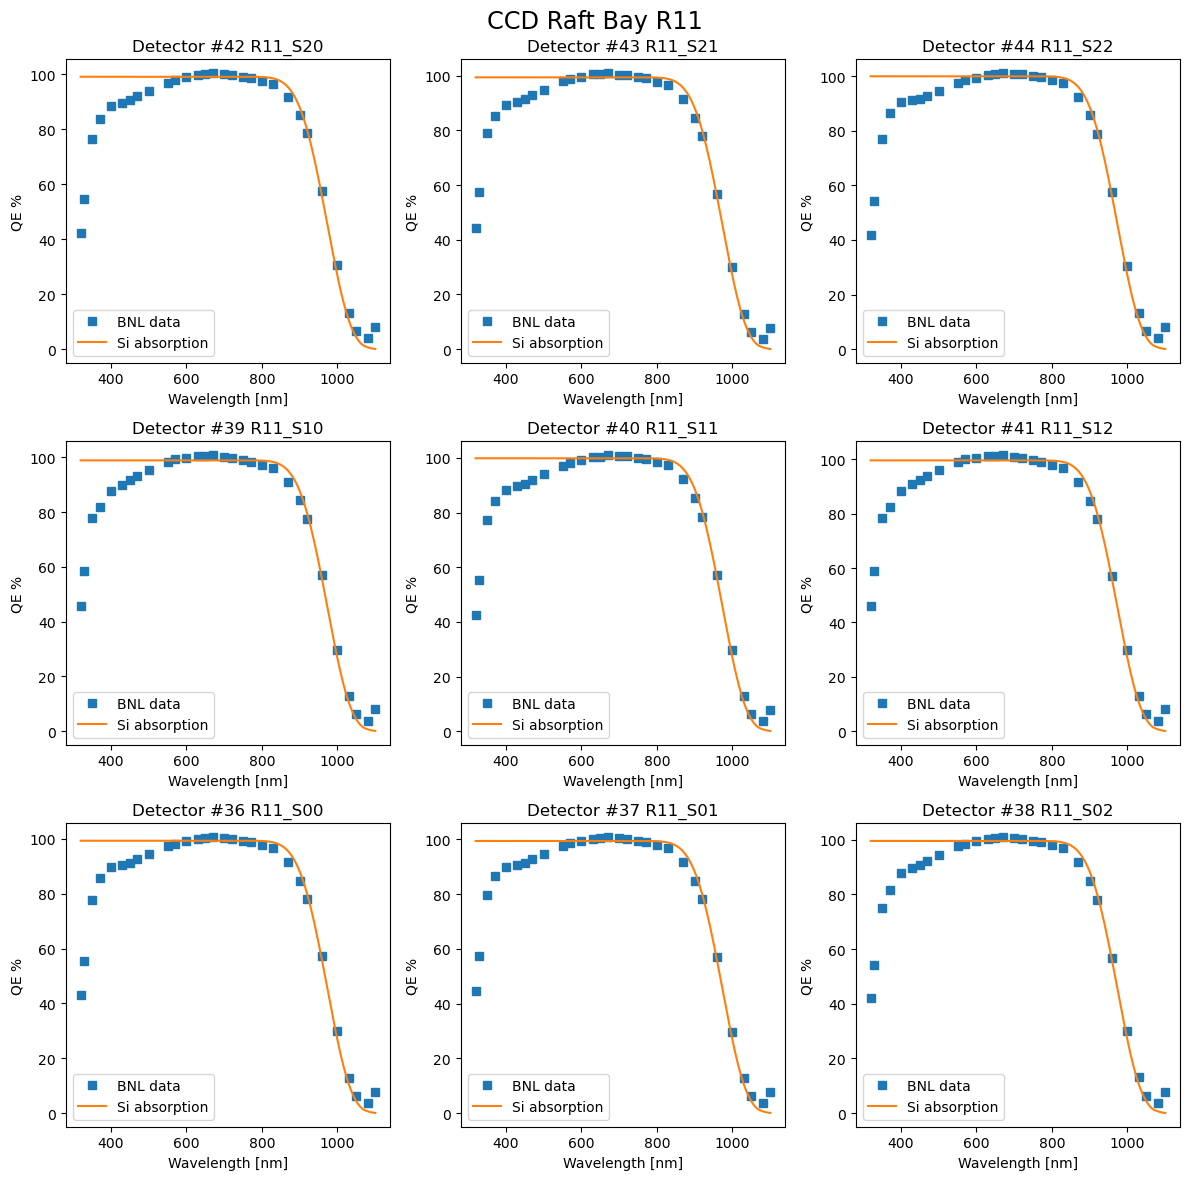

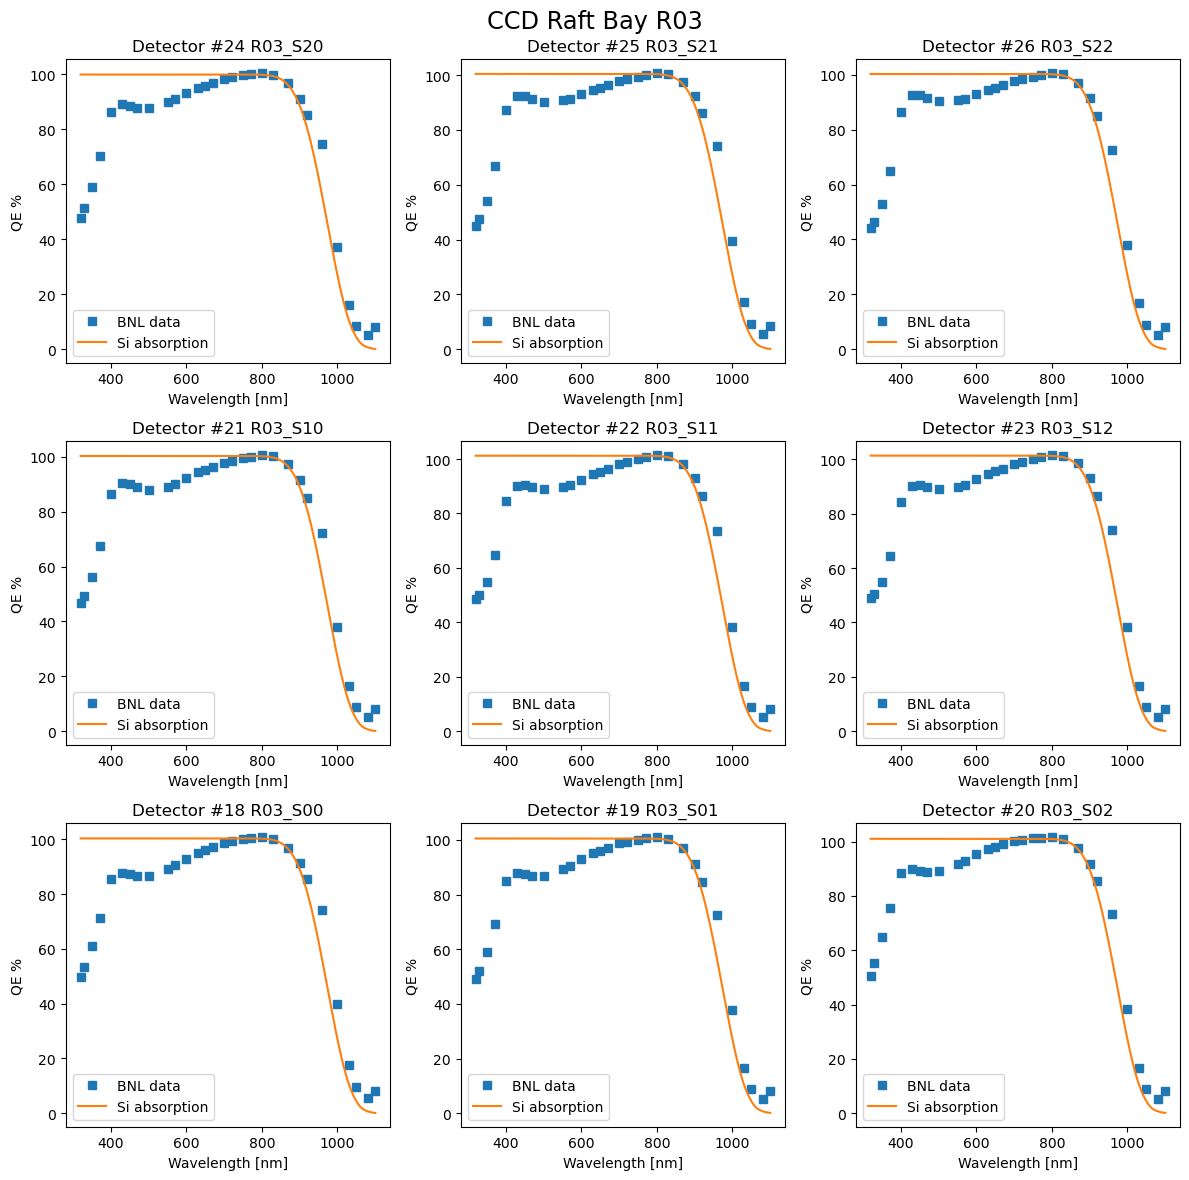

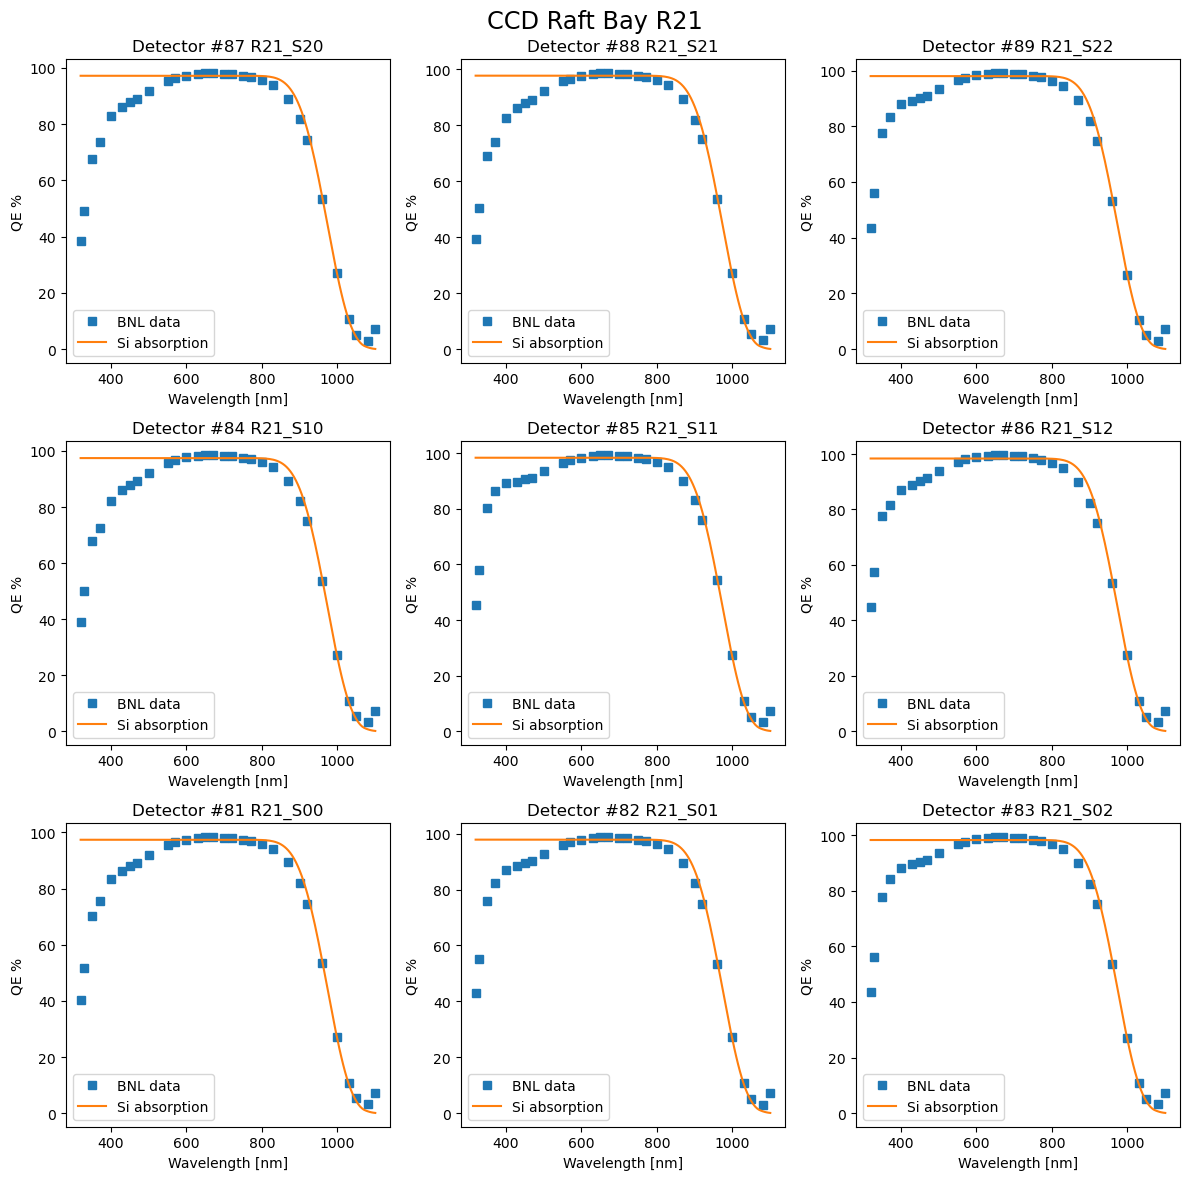

In [19]:
# check 4 rafts with BNL data used: R32, R11, R03, R21

redcompare_ccd_qe_raft('R32',df_slac,wlnorm=750.,label1='BNL data')
redcompare_ccd_qe_raft('R11',df_slac,wlnorm=750.,label1='BNL data')
redcompare_ccd_qe_raft('R03',df_slac,wlnorm=825.,label1='BNL data')  #didn't look good with normalization at 750
redcompare_ccd_qe_raft('R21',df_slac,wlnorm=750.,label1='BNL data')

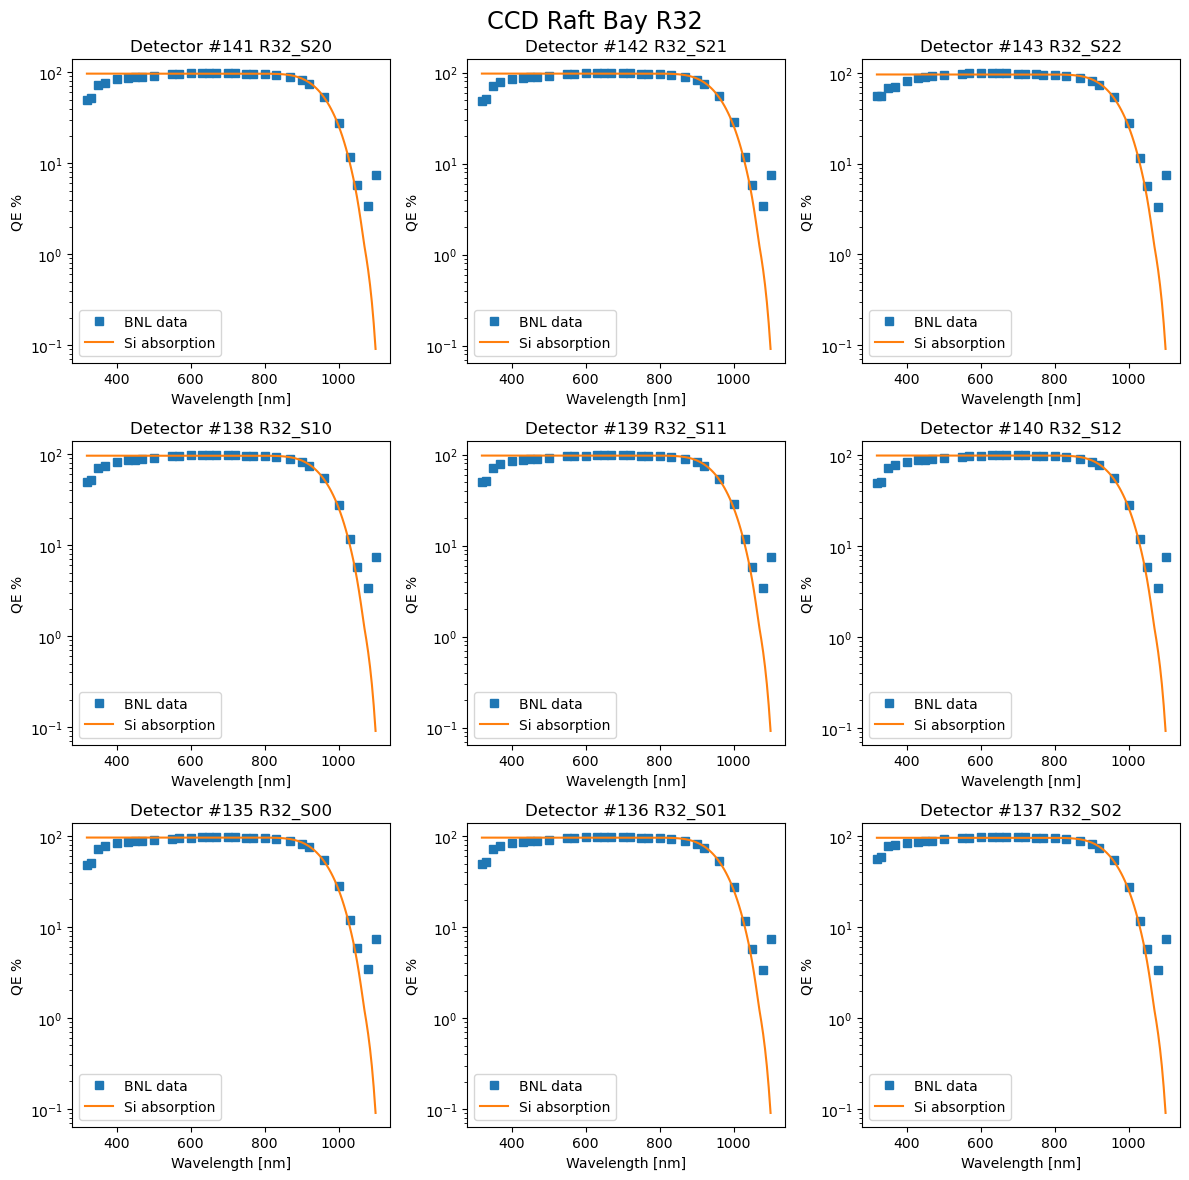

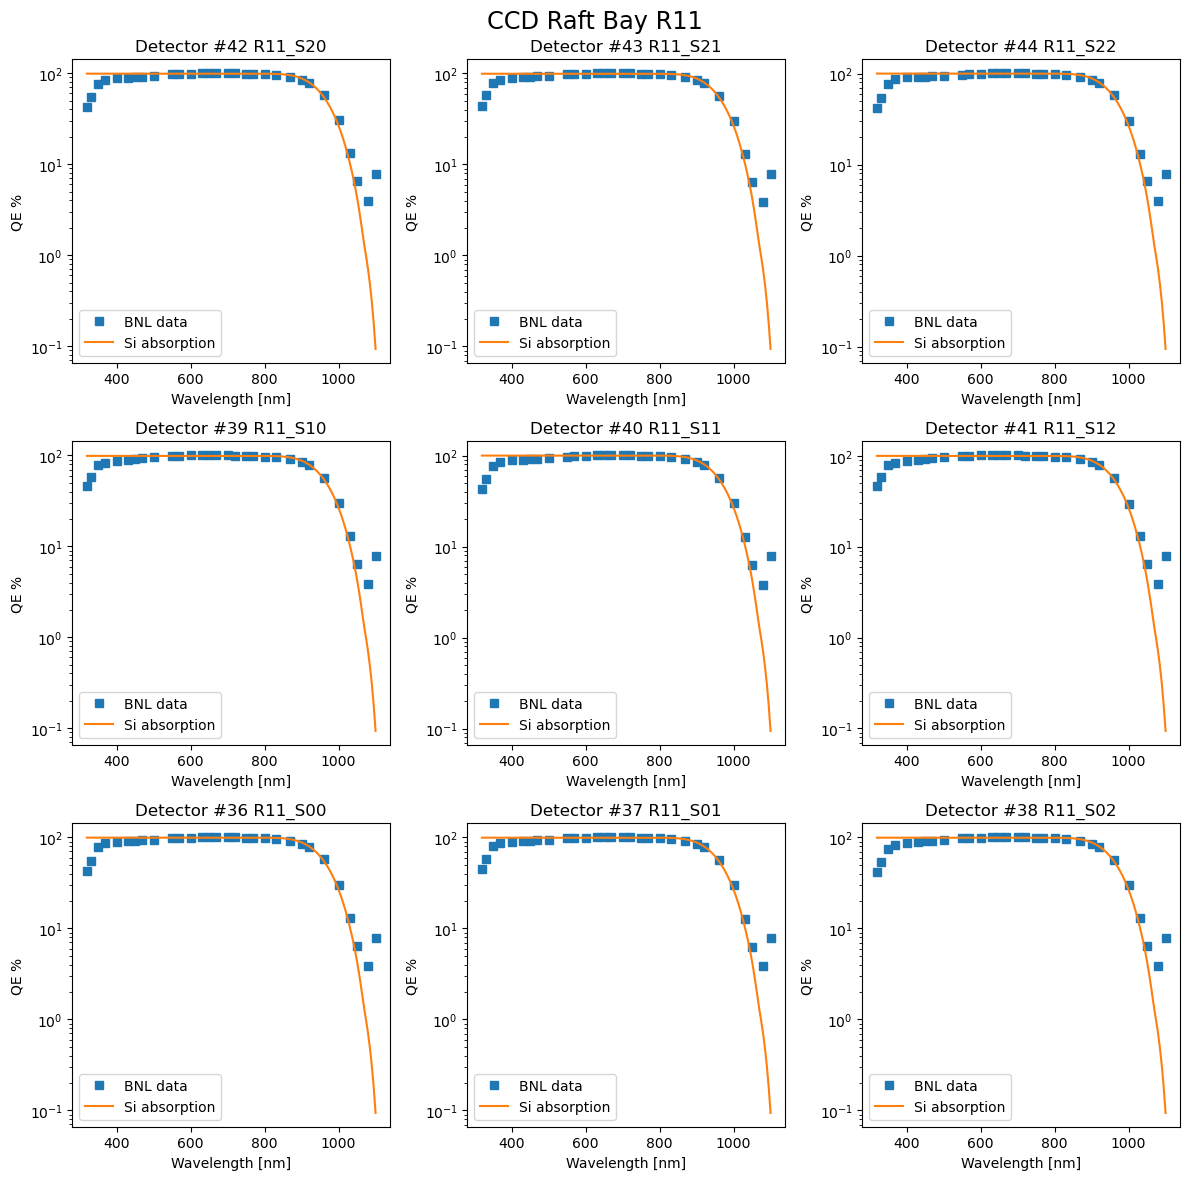

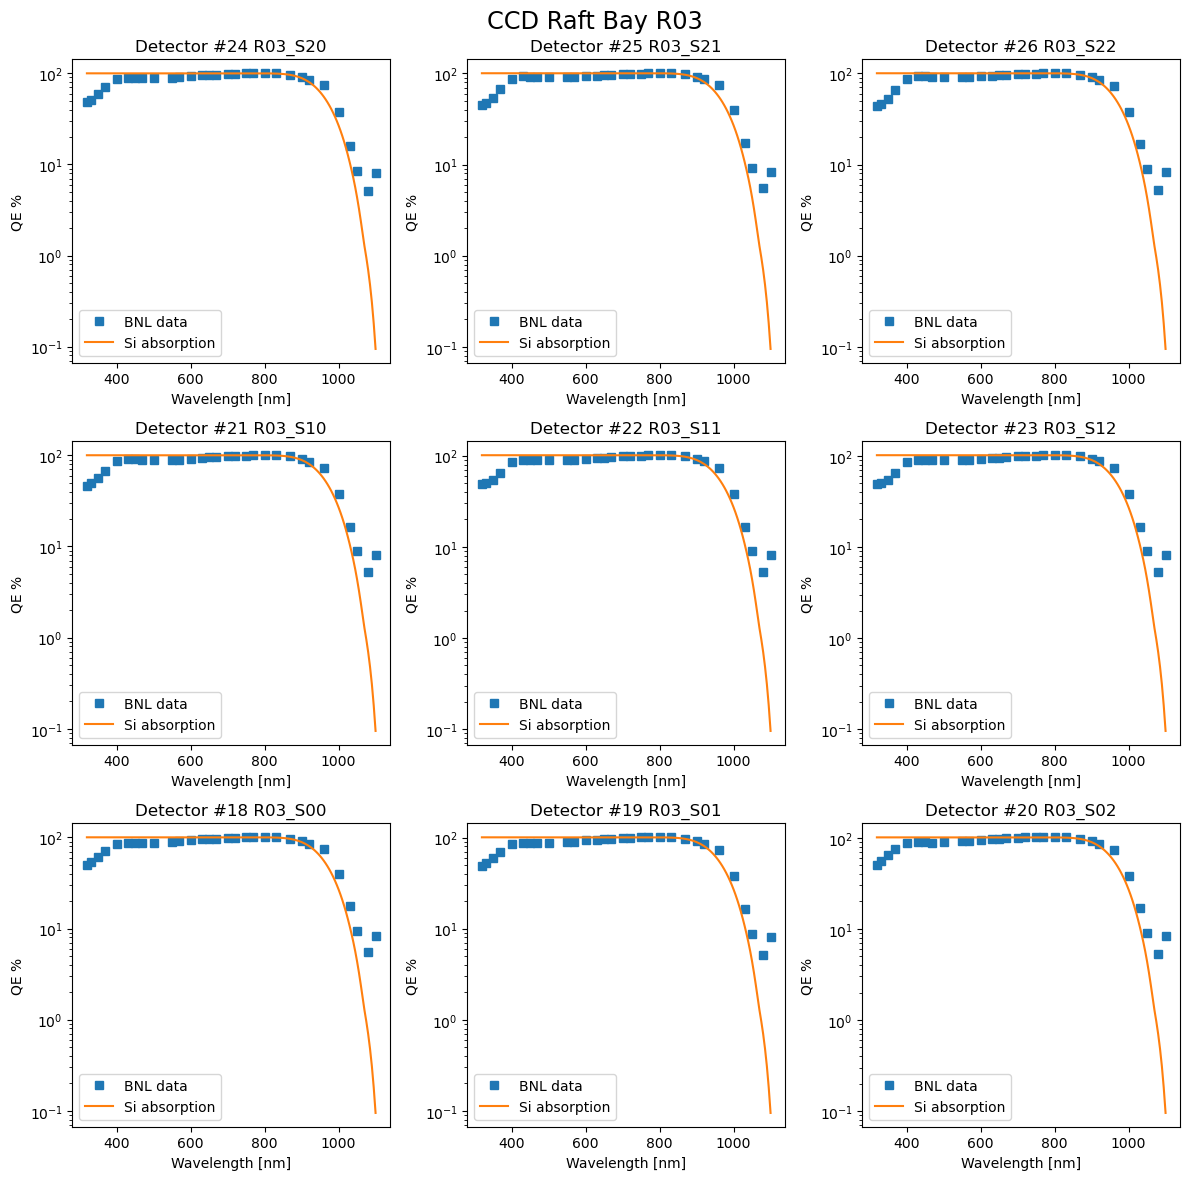

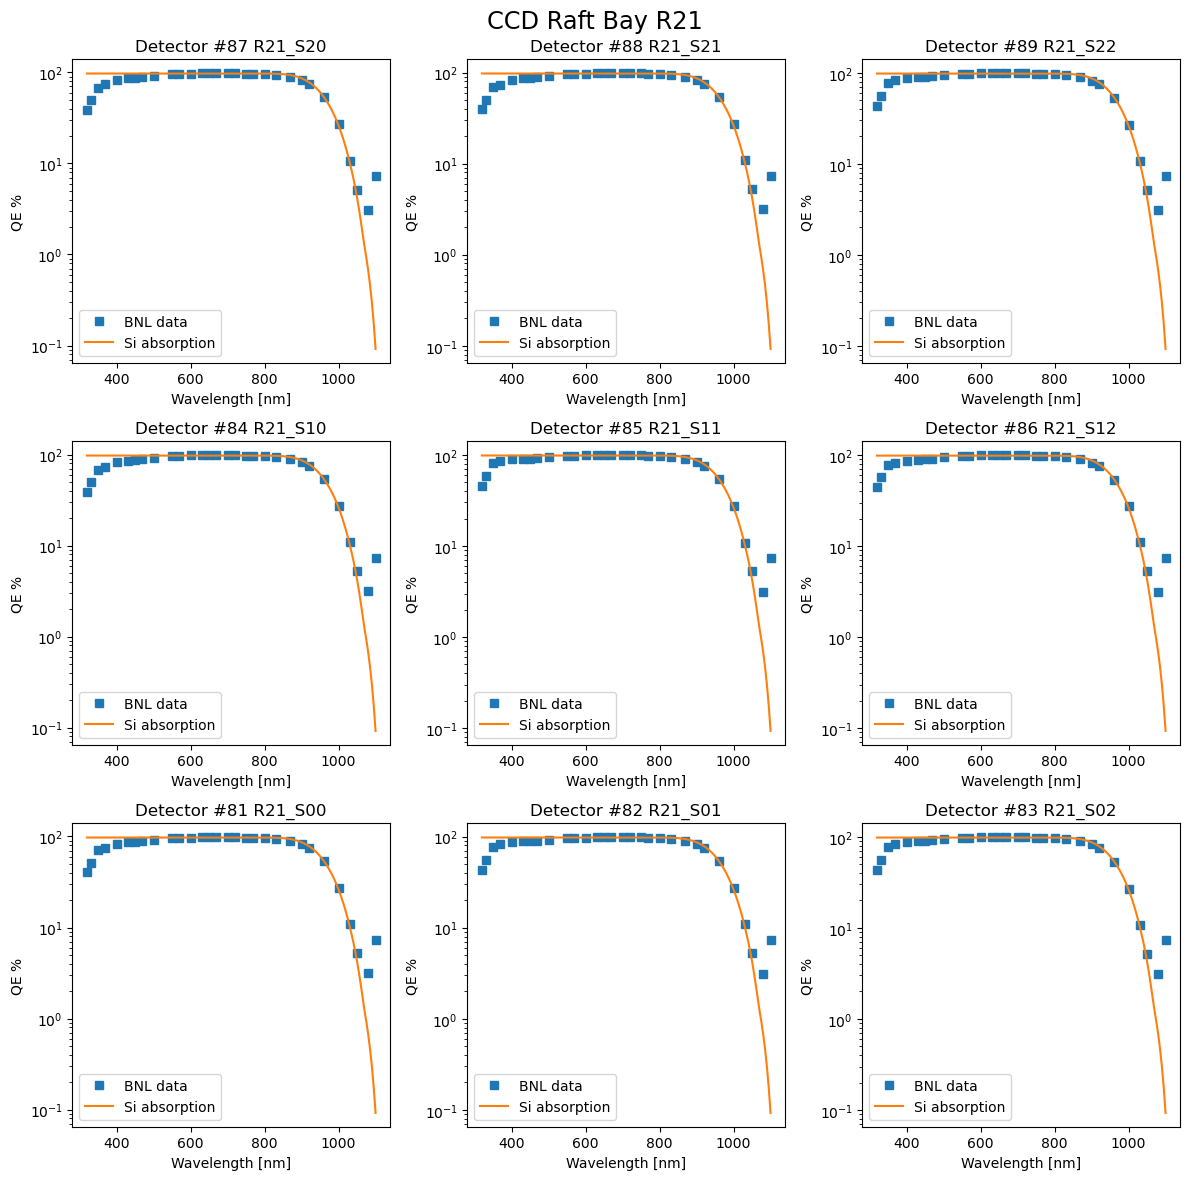

In [20]:

redcompare_ccd_qe_raft('R32',df_slac,wlnorm=750.,label1='BNL data',uselog=True)
redcompare_ccd_qe_raft('R11',df_slac,wlnorm=750.,label1='BNL data',uselog=True)
redcompare_ccd_qe_raft('R03',df_slac,wlnorm=825.,label1='BNL data',uselog=True)  #didn't look good with normalization at 750
redcompare_ccd_qe_raft('R21',df_slac,wlnorm=750.,label1='BNL data',uselog=True)

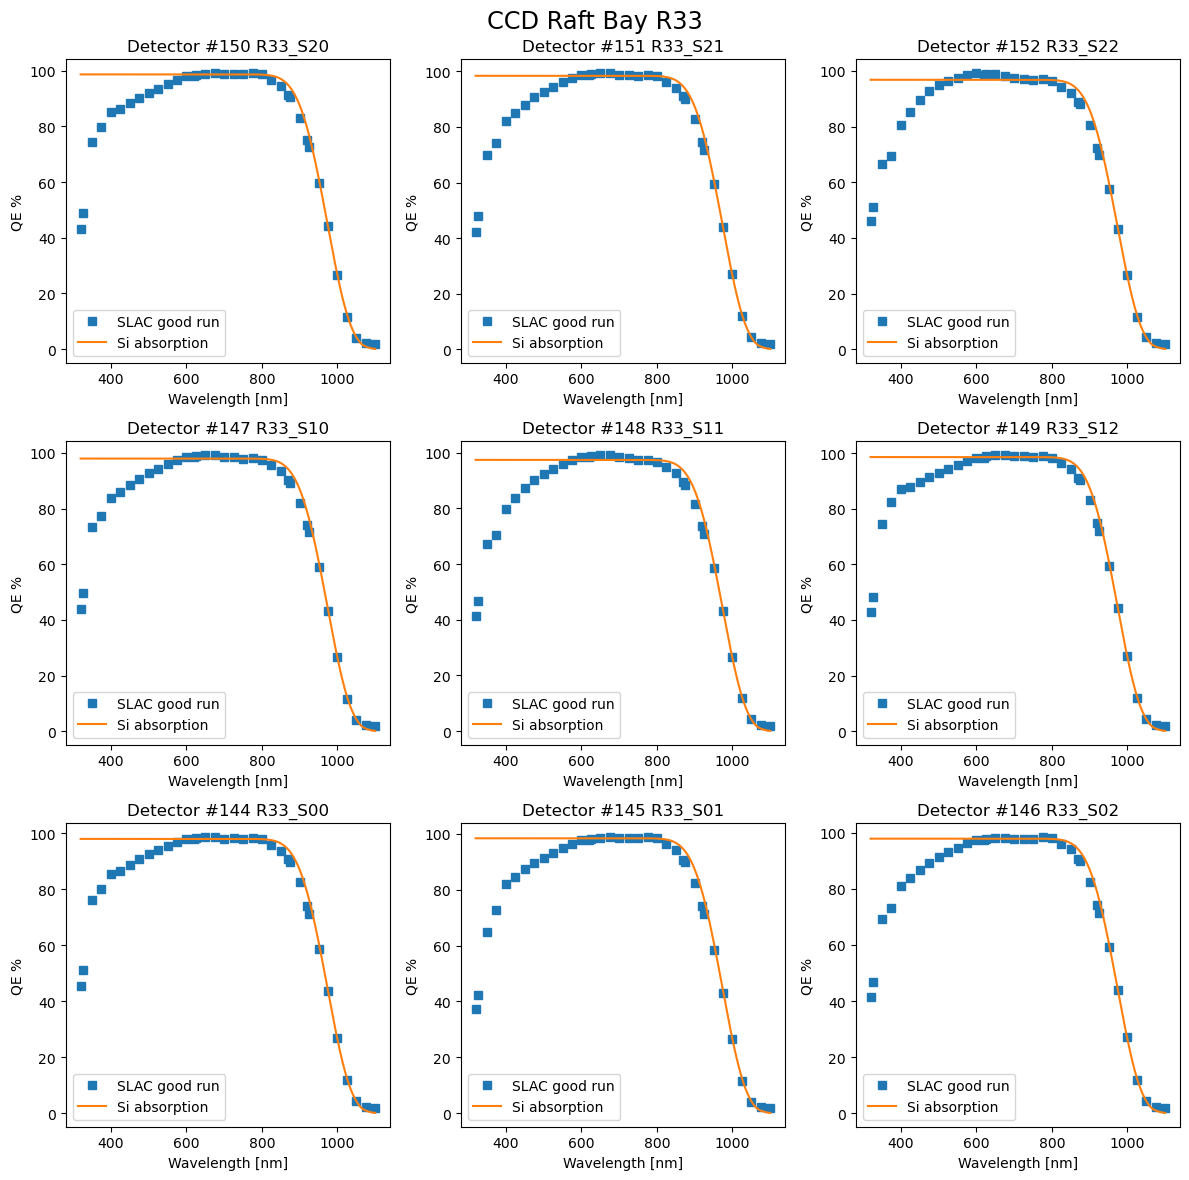

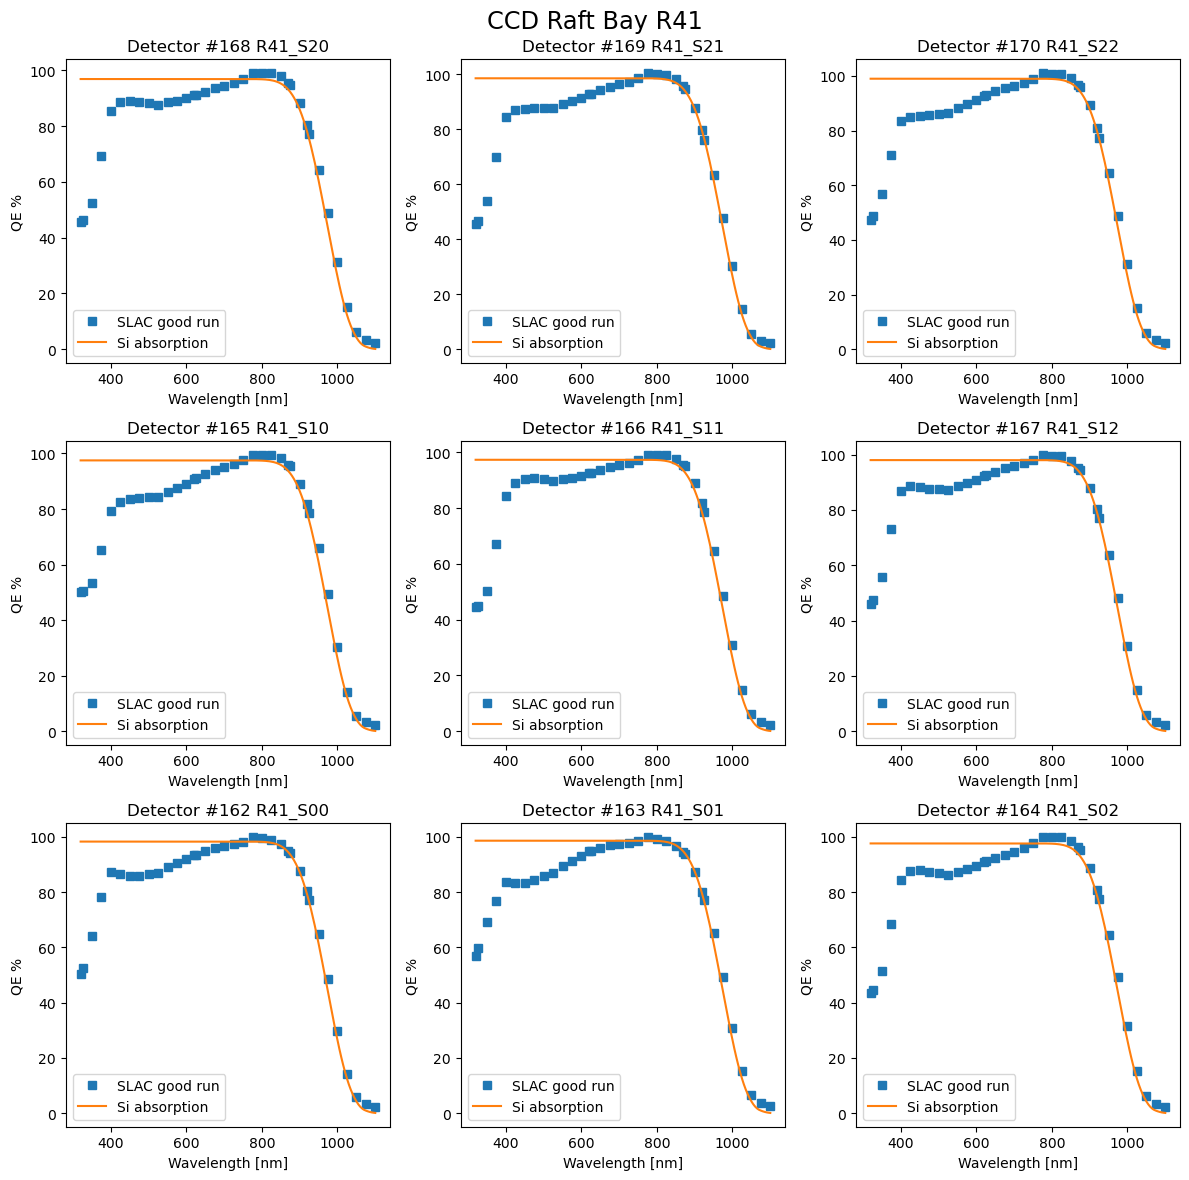

In [21]:
redcompare_ccd_qe_raft('R33',df_slac,wlnorm=750.,label1='SLAC good run')
redcompare_ccd_qe_raft('R41',df_slac,wlnorm=750.,label1='SLAC good run')

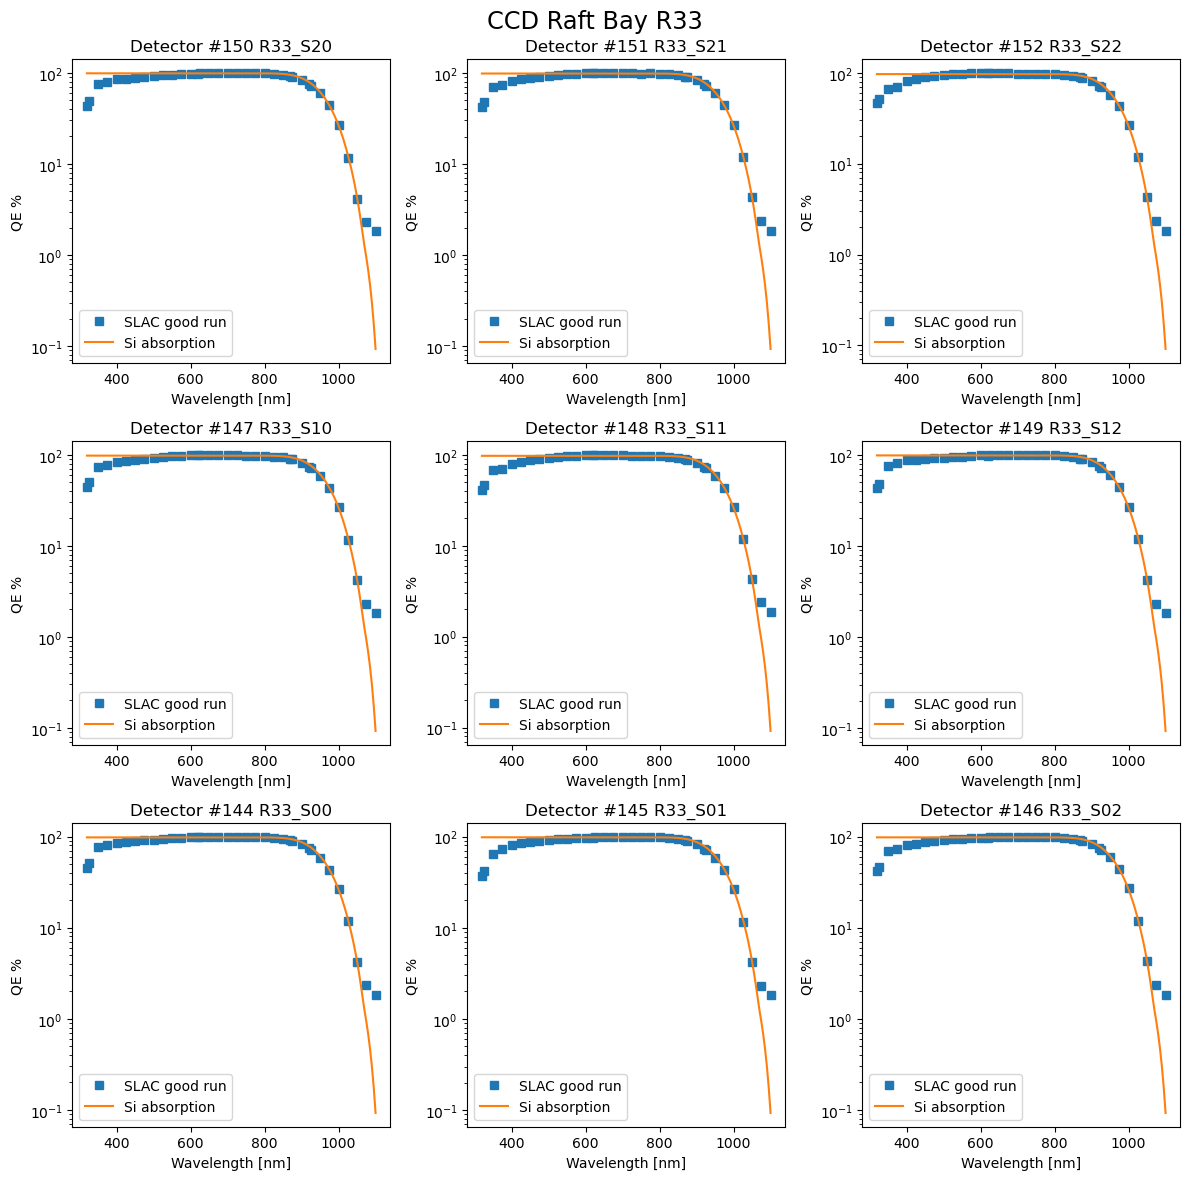

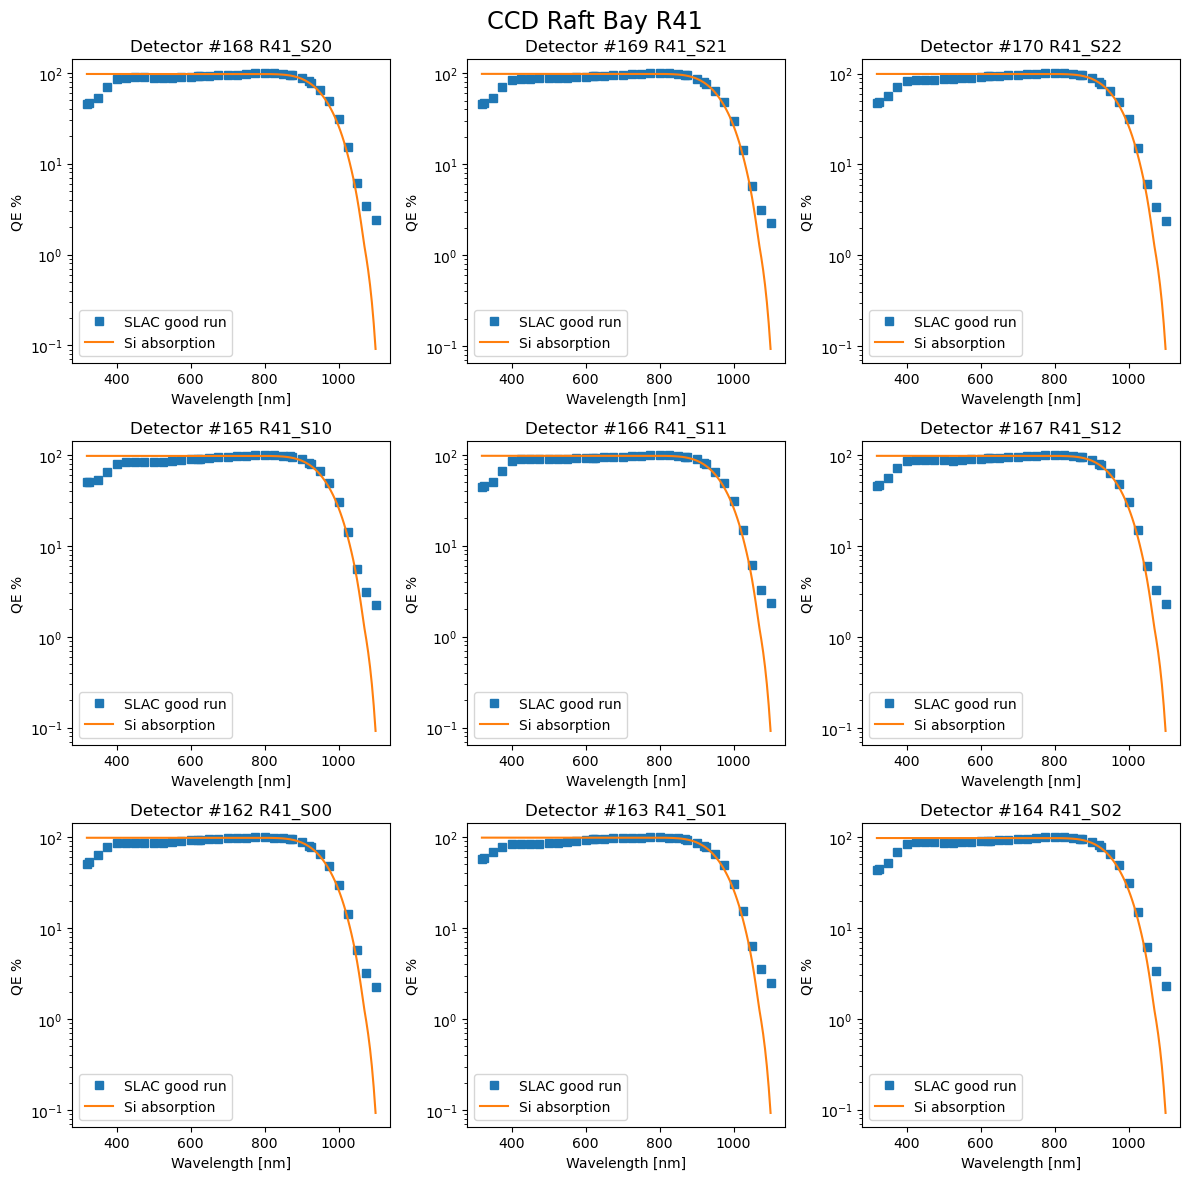

In [22]:
redcompare_ccd_qe_raft('R33',df_slac,wlnorm=750.,uselog=True,label1='SLAC good run')
redcompare_ccd_qe_raft('R41',df_slac,wlnorm=750.,uselog=True,label1='SLAC good run')

# devise a correction algorithm for the highest wavelength points

## all single raft tests look to have higher QE than is physical at 1075 and 1100 nm, BNL is worse, but SLAC data also looks to be at 2% at 1075 when a max of 1% is expected

## with SLAC data: the sample ITL raft R41 shows somewhat higher QE on the red edge than expected from Si absorption, while the e2v R33 matches well up to 1050nm.  Could this be a real effect, with more reflection at the front side in ITL than e2v, and so effectively a thicker sensor?

In [50]:
df_corr = df_slac.copy()
df_corr['qecorr'] = df_corr['qe']

In [51]:
print(df_corr)

        idet           wl         qe slot  bay  seg     qecorr
0          0   319.993988  48.629013  S00  R01  Ave  48.629013
1          0   319.993988  49.821590  S00  R01  C10  49.821590
2          0   319.993988  49.369022  S00  R01  C11  49.369022
3          0   319.993988  49.053307  S00  R01  C12  49.053307
4          0   319.993988  48.884781  S00  R01  C13  48.884781
...      ...          ...        ...  ...  ...  ...        ...
111991   188  1099.989990   2.277960  S22  R43  C04   2.277960
111992   188  1099.989990   2.280380  S22  R43  C03   2.280380
111993   188  1099.989990   2.281878  S22  R43  C02   2.281878
111994   188  1099.989990   2.280678  S22  R43  C01   2.280678
111995   188  1099.989990   2.259089  S22  R43  C00   2.259089

[111996 rows x 7 columns]


In [67]:
# correct all QE values above 1051nm, using normalization to a lower wavelength 
# and the expected QE from Si absorption

def correct_ccd_qe_raft(dfall,wlnorm=825.,ccdtemp=-100.0):

    waves = np.arange(320.,1100.+1.0,1.)
    
    T = 273.16 + ccdtemp # in Kelvin
    alphas = np.array([alpham(lam,T) for lam in waves])
    L = 100.0 * 1.0e-4 # convert to cm
    prob_100 = 1.0 - np.exp(-alphas*L)
    aninterp_Si = PchipInterpolator(waves,prob_100,extrapolate=True)
    
    for idet in range(189):
        for segment in segments:
        
            dfone = dfall[(dfall.idet==idet) & (dfall.seg==segment)]
            x1 = dfone['wl']
            y1 = dfone['qe']
            aninterp1 = PchipInterpolator(x1,y1,extrapolate=True)
            qe1 = aninterp1(waves)
        
            # normalize 
            qenorm = aninterp1(wlnorm)
            
            # now get and change the QE at points at 1075 and 1100 based on the normalized Si absorption
            dfnir = dfall[(dfall.idet==idet) & (dfall.seg==segment) & (dfall.wl>1051.)]
            
            # loop over points
            for index,row in dfnir.iterrows():
                wl = row['wl']
                oldqe = row['qe']
                newqe = qenorm * aninterp_Si(wl)
                dfall.at[index,'qecorr'] = newqe
                        

In [68]:
correct_ccd_qe_raft(df_corr)

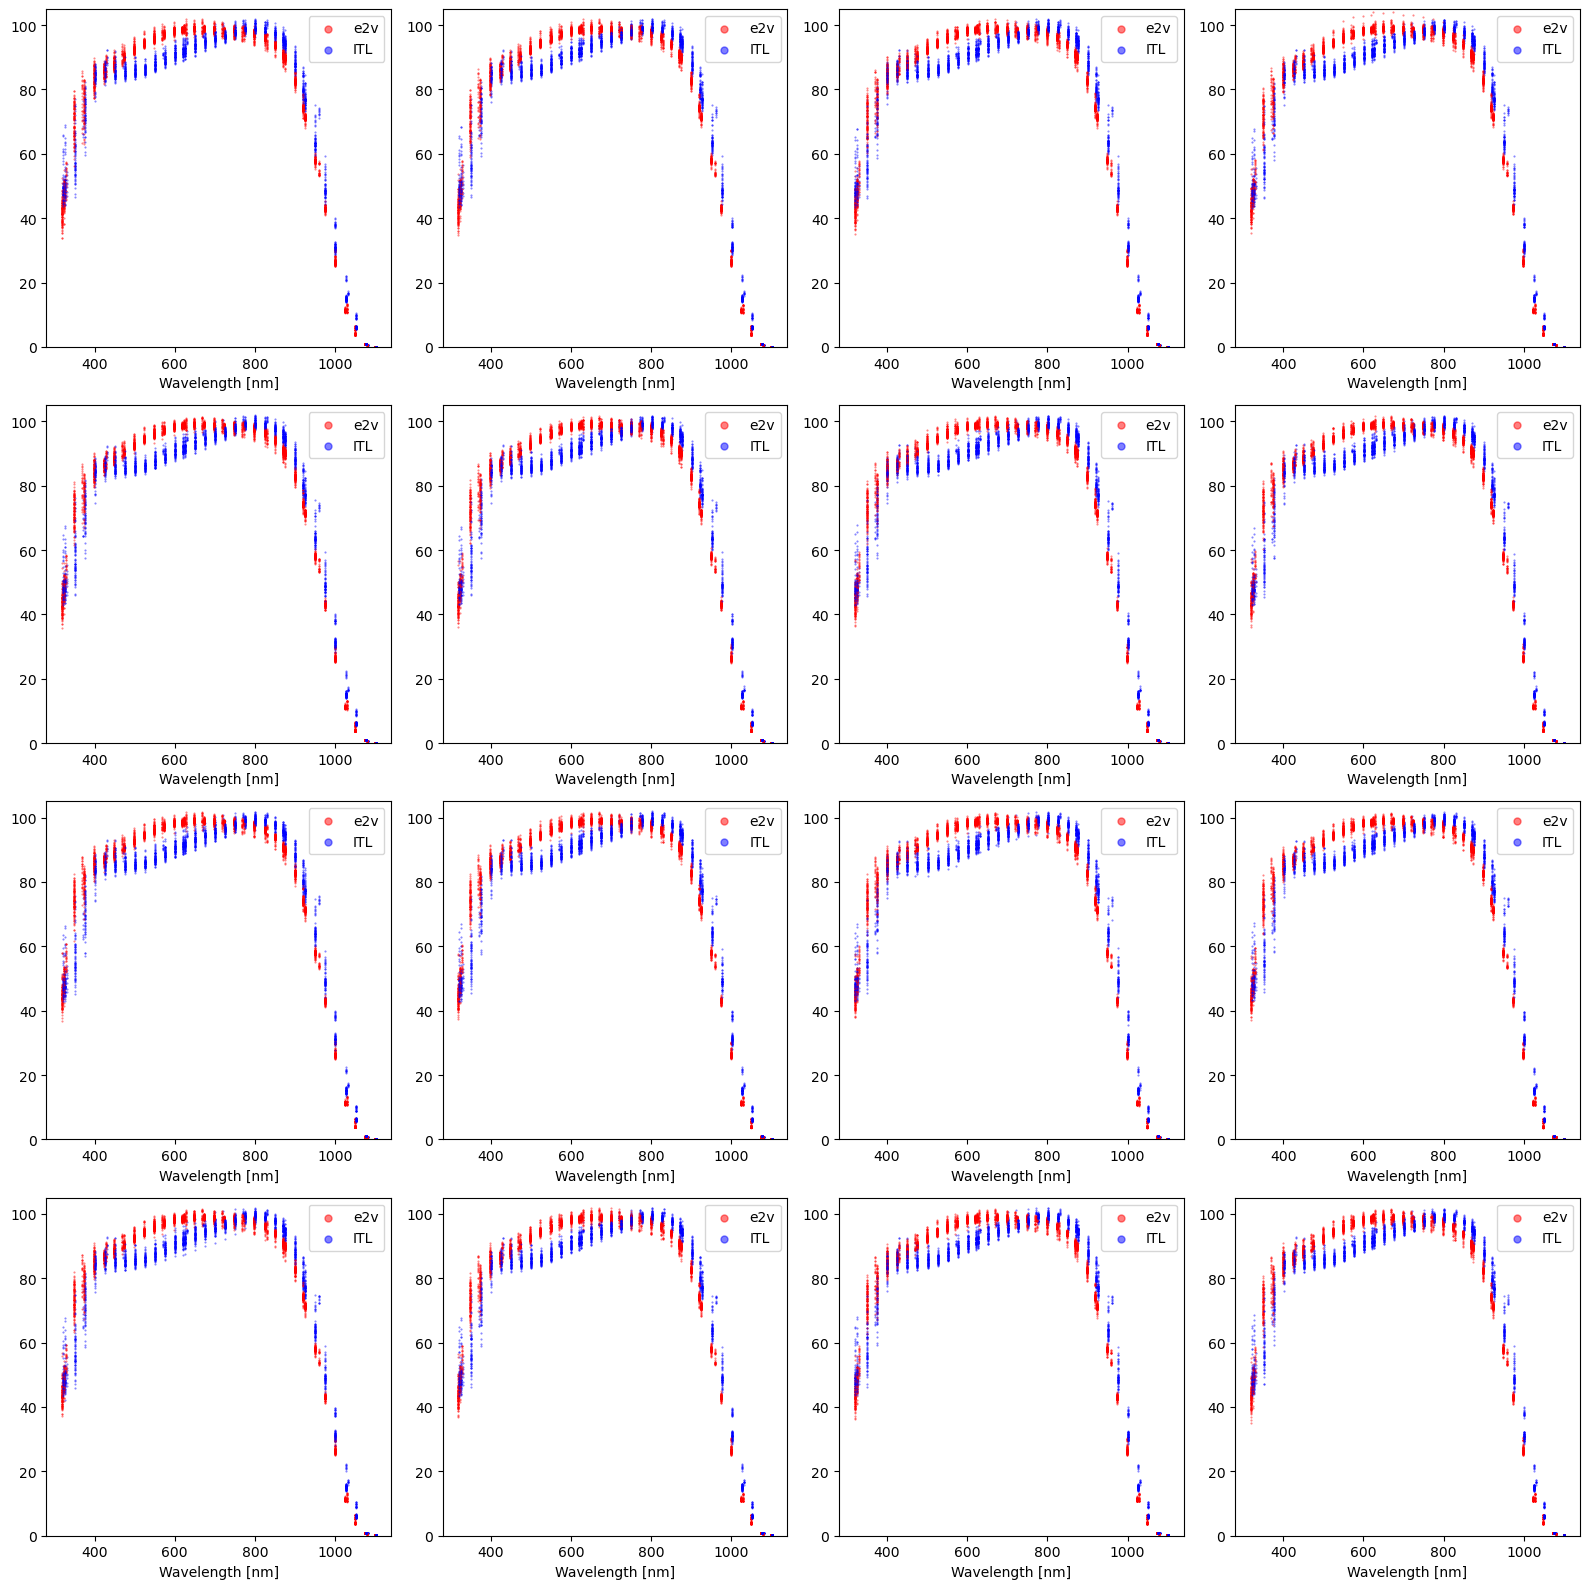

In [69]:
f,ax = plt.subplots(4,4,figsize=(16,16))
ax = ax.flatten()
for jamp,asegment in enumerate(segments):

    for i in range(189):
        dfone = df_corr[(df_corr.idet==i)&(df_corr.seg==asegment)]
        ptype = det_ptypes[i]
        if ptype=='E2V':
            an_e2v = i
            points_e2v = ax[jamp].scatter(dfone['wl']-1.0,dfone['qecorr'],marker='.',c='red',s=1.0,alpha=0.5,label='e2v')
        elif ptype=='ITL':
            an_itl = i
            points_itl = ax[jamp].scatter(dfone['wl']+1.0,dfone['qecorr'],marker='.',c='blue',s=1.0,alpha=0.5,label='ITL')
            
    ax[jamp].set_xlabel('Wavelength [nm]')
    ax[jamp].set_ylim(0.,105.)
    #ax[iamp].set_title('QE, Single Raft Data')

    handles, labels = ax[jamp].get_legend_handles_labels()
    ax[jamp].legend([handles[an_e2v],handles[an_itl]], [labels[an_e2v],labels[an_itl]],markerscale=10.)
    
f.tight_layout()

In [70]:
df_corr.to_parquet('qe_raft_allvalues_nircorrected_20230725.parquet')